# Разработка AI помощника в виде Telegram-бота для рекомендаций фильмов с использованием классических методов машинного обучения

## Описание задачи

Цель данного проекта — создать интеллектуального помощника в виде Telegram-бота, который сможет рекомендовать фильмы пользователям на основе их предпочтений и рейтингов. Проект включает в себя сбор и анализ данных, построение модели рекомендаций, интеграцию модели в Telegram-бот и визуализацию данных для понимания влияющих факторов.

## Выбор датасета

Для решения данной задачи был выбран публичный датасет [MovieLens](https://grouplens.org/datasets/movielens/), предоставляемый исследовательской группой GroupLens. Датасет содержит информацию о миллионах оценок пользователей различных фильмов, что делает его идеальным для построения системы рекомендаций.

## Описание данных

Датасет MovieLens состоит из нескольких файлов, ключевыми из которых являются:

- **movie.csv**: Содержит информацию о фильмах, включая идентификатор, название и жанры.
- **rating.csv**: Содержит оценки пользователей для фильмов, включая идентификатор пользователя, идентификатор фильма, оценку и временную метку.
- **tags.csv**: Содержит теги, присвоенные пользователями фильмам.
- **links.csv**: Содержит ссылки на сторонние сайты для фильмов.

Для данного проекта будут использованы файлы `movie.csv` и `rating.csv`.

## Этапы решения

1. **Импорт необходимых библиотек**
2. **Загрузка и предварительный анализ данных**
3. **Визуализация данных**
4. **Предобработка данных**
5. **Построение модели рекомендаций**
6. **Разработка Telegram-бота**
7. **Интеграция модели в Telegram-бот**
8. **Тестирование и оценка качества системы**
9. **Выводы и рекомендации**

## Реализация

### 1. Импорт необходимых библиотек

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import logging
import requests
import json

%matplotlib inline

### 2. Загрузка и предварительный анализ данных

In [23]:
# Загрузка данных
movies = pd.read_csv('archive/movie.csv')
ratings = pd.read_csv('archive/rating.csv')

# Просмотр первых строк
print(movies.head())
print(ratings.head())

# Информация о данных
print(movies.info())
print(ratings.info())

# Статистическая сводка
print(ratings.describe())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Colu

### 3. Визуализация данных

#### Распределение оценок

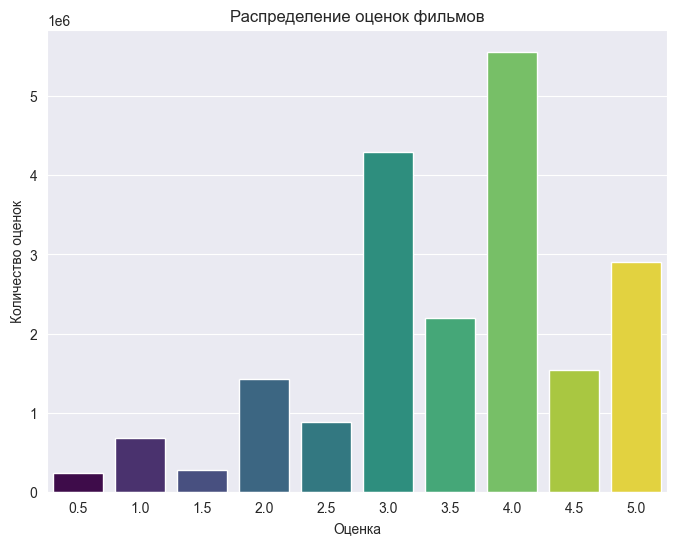

In [7]:
plt.figure(figsize=(8,6))
sns.countplot(x='rating', data=ratings, hue='rating', palette='viridis')
plt.title('Распределение оценок фильмов')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
plt.legend([],[], frameon=False)  # Отключение легенды
plt.show()


#### Среднее количество оценок на фильм

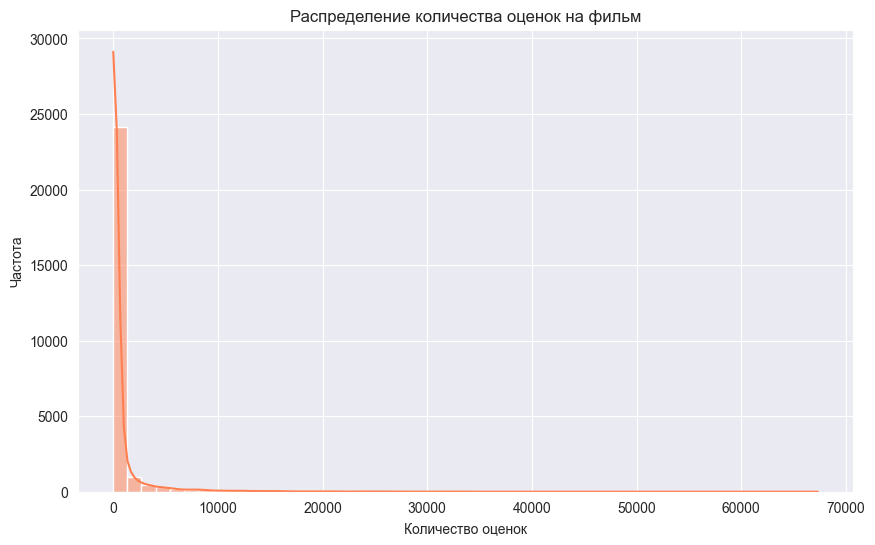

In [9]:
plt.figure(figsize=(10,6))
ratings_per_movie = ratings.groupby('movieId').size()
sns.histplot(ratings_per_movie, bins=50, kde=True, color='coral')
plt.title('Распределение количества оценок на фильм')
plt.xlabel('Количество оценок')
plt.ylabel('Частота')
plt.show()

### 4. Предобработка данных

- **Фильтрация данных**: Удаление фильмов с малым количеством оценок для повышения надежности рекомендаций.
- **Создание матрицы оценок**: Построение матрицы пользователей и фильмов.
- **Преобразование жанров**: Создание бинарных признаков для жанров фильмов.

In [24]:
# Фильтрация фильмов с менее чем 50 оценками
movie_counts = ratings['movieId'].value_counts()
filtered_movies = movie_counts[movie_counts >= 50].index
ratings_filtered = ratings[ratings['movieId'].isin(filtered_movies)]

# Обновление списка фильмов
movies_filtered = movies[movies['movieId'].isin(filtered_movies)]

# Создание матрицы оценок
user_movie_matrix = ratings_filtered.pivot_table(index='userId', columns='movieId', values='rating')

# Преобразование жанров в бинарные признаки
all_genres = movies_filtered['genres'].str.get_dummies(sep='|')
movies_filtered = pd.concat([movies_filtered, all_genres], axis=1)

print(movies_filtered.head())
print(user_movie_matrix.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  Action  Adventure  Animation  \
0  Adventure|Animation|Children|Comedy|Fantasy       0          1          1   
1                   Adventure|Children|Fantasy       0          1          0   
2                               Comedy|Romance       0          0          0   
3                         Comedy|Drama|Romance       0          0          0   
4                                       Comedy       0          0          0   

   Children  Comedy  Crime  Documentary  ...  Film-Noir  Horror  IMAX  \
0         1       1      0            0  ...          0       0     0   
1         1       0      0            0  ...          0       0     0   

### 5. Построение модели рекомендаций

Для построения системы рекомендаций будет использован **Content-Based Filtering** с использованием косинусного сходства на основе жанров фильмов.

In [25]:
# Вычисление косинусного сходства между жанрами фильмов
genre_similarity = cosine_similarity(all_genres)
genre_similarity_df = pd.DataFrame(genre_similarity, index=movies_filtered['movieId'], columns=movies_filtered['movieId'])

# Функция для получения рекомендаций
def get_recommendations(movie_id, similarity_matrix, movies_df, top_n=5):
    similar_scores = similarity_matrix[movie_id].sort_values(ascending=False)
    similar_scores = similar_scores.drop(labels=[movie_id])  # Исключение самого фильма
    top_movies = similar_scores.head(top_n).index
    return movies_df[movies_df['movieId'].isin(top_movies)]['title'].tolist()

### 6. Разработка Telegram-бота

In [26]:
# Настройка логирования
logging.basicConfig(
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    level=logging.INFO
)
logger = logging.getLogger(__name__)

### 7. Интеграция модели в Telegram-бот

In [27]:
# Загрузка конфигурации
def load_config(file_path):
    try:
        with open(file_path, 'r') as file:
            config = json.load(file)
            return config.get("TOKEN")
    except FileNotFoundError:
        print(f"Ошибка: Файл {file_path} не найден.")
        return None
    except json.JSONDecodeError:
        print("Ошибка: Неверный формат JSON.")
        return None
    except Exception as e:
        print(f"Произошла ошибка: {e}")
        return None

In [28]:
# Функция для отправки сообщений через Telegram API
def send_message(token, chat_id, text):
    url = f"https://api.telegram.org/bot{token}/sendMessage"
    payload = {
        "chat_id": chat_id,
        "text": text
    }
    response = requests.post(url, json=payload)
    return response.json()

In [29]:
from deep_translator import GoogleTranslator

# Основная функция для обработки входящих обновлений
def process_update(token, update):
    message = update.get("message")
    if not message:
        return

    chat_id = message["chat"]["id"]
    text = message.get("text", "").strip()

    if text.startswith("/start"):
        send_message(token, chat_id,
                     "Здравствуйте! Я бот-рекомендатор фильмов. Введите название фильма, и я порекомендую вам похожие фильмы.")
    else:
        # Первоначальный поиск по введенному тексту
        movie = movies_filtered[movies_filtered['title'].str.contains(text, case=False, regex=False)]
        
        if movie.empty:
            # Если фильм не найден, переводим запрос на английский
            try:
                # Переводим текст с русского на английский
                translated_text = GoogleTranslator(source='ru', target='en').translate(text)
            except Exception as e:
                send_message(token, chat_id, "Произошла ошибка при переводе. Пожалуйста, попробуйте позже.")
                return
            
            # Повторный поиск по переведенному тексту
            movie = movies_filtered[movies_filtered['title'].str.contains(translated_text, case=False, regex=False)]
            
            if movie.empty:
                # Если фильм все еще не найден
                response = f"Извините, я не нашел фильм с названием '{text}'. Пожалуйста, попробуйте другое название."
            else:
                # Если фильм найден после перевода
                movie_id = movie.iloc[0]['movieId']
                recommendations = get_recommendations(movie_id, genre_similarity_df, movies_filtered, top_n=5)
                response = f"Если вам понравился фильм '{movie.iloc[0]['title']}', вам также могут понравиться:\n"
                for rec in recommendations:
                    response += f"- {rec}\n"
        else:
            # Если фильм найден с оригинальным запросом
            movie_id = movie.iloc[0]['movieId']
            recommendations = get_recommendations(movie_id, genre_similarity_df, movies_filtered, top_n=5)
            response = f"Если вам понравился фильм '{movie.iloc[0]['title']}', вам также могут понравиться:\n"
            for rec in recommendations:
                response += f"- {rec}\n"
        
        send_message(token, chat_id, response)

In [30]:
# Основная функция для запуска бота
def main():
    TOKEN = load_config('config.json')
    if not TOKEN:
        print("Не удалось загрузить токен.")
        return

    url = f"https://api.telegram.org/bot{TOKEN}/getUpdates"
    offset = None

    print("Бот запущен...")
    while True:
        params = {"offset": offset, "timeout": 100}
        response = requests.get(url, params=params)
        updates = response.json().get("result", [])

        for update in updates:
            process_update(TOKEN, update)
            offset = update["update_id"] + 1


if __name__ == '__main__':
    main()


Бот запущен...


KeyboardInterrupt: 